In [1]:
import numpy as np
import math

import torch
import torch.nn as nn
from torch.autograd import Function
import torchsummary

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Parameter

In [3]:
batch_size = 128
n_epochs = 100
z_dim = 100

In [4]:
cuda = True if torch.cuda.is_available() else False
cuda

True

# Data

In [5]:
# torchvision의 데이터가 PIL.Image.Image 타입으로 들어온다. 
# Tensor로 변경하기 위해 transform 부분을 넣어준다.

# train=True 면 학습데이터, train=False면 테스트 데이터

path_data = '/content/drive/MyDrive/Colab Notebooks/gan/data'

dataloader = DataLoader(
    datasets.MNIST(path_data, 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([transforms.ToTensor()])), 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True)

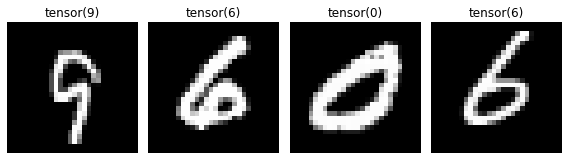

In [6]:
images, labels = next(iter(dataloader))

fig = plt.figure(figsize=(8, 8))
for idx in range(4):
  image = images[idx]
  label = labels[idx]

  fig.add_subplot(1, 4, idx+1)
  plt.axis('off')
  plt.title(label)
  plt.imshow(image[0], cmap='gray')

fig.tight_layout()
plt.savefig(path_data+'/mnist_test.png', dpi=300)
plt.show()

# Model

In [7]:
# relu activation, sigmoid activation 사용
class Generator(nn.Module):
  def __init__(self, z_dim=100, img_shape=(28,28)):
    super(Generator, self).__init__()

    self.z_dim = z_dim
    self.img_shape=img_shape

    self.model = nn.Sequential(
        nn.Linear(self.z_dim, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Sigmoid()
    )

  def forward(self, z):
      img = self.model(z)
      img = img.view(img.size(0), *self.img_shape)
      return img

In [8]:
class Maxout(nn.Module):
  def __init__(self, k=3):
    super(Maxout, self).__init__()

    self.k = k

    self.weight = torch.randn(self.k, requires_grad=True).unsqueeze(1).cuda()
    self.bias = torch.randn(self.k, requires_grad=True).unsqueeze(0).cuda()

  def forward(self, input):
    x = input.flatten().unsqueeze(1)
    x = nn.functional.linear(x, self.weight, self.bias)
    x = nn.functional.max_pool1d(x, self.k)
    x = x.reshape(*input.shape)
    return x


class Discriminator(nn.Module):
  def __init__(self, img_shape=28*28):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(img_shape, 512),
        Maxout(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        Maxout(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, img):
    output = self.model(img)
    return output

# Train

In [9]:
generator = Generator()
discriminator = Discriminator()

In [10]:
loss = nn.BCELoss().cuda()

In [11]:
generator.cuda()
discriminator.cuda()
loss.cuda()

BCELoss()

In [12]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001)

In [13]:
sample = torch.zeros(batch_size, z_dim)
sample += (0.1**0.5)*torch.randn(batch_size, z_dim)
sample = sample.cuda()

ones = ((torch.rand(batch_size, 1) * 0.1) + 0.9).cuda()
ones.requires_grad = False
zeros = torch.zeros(batch_size, 1).cuda()
zeros.requires_grad = False

In [14]:
history = {'D': [], 'G': []}
list_test = []

In [15]:
# k = 1

for epoch in range(n_epochs):
  time_before = datetime.now()

  for i, (images, labels) in enumerate(dataloader):
    images = images.reshape(batch_size, -1).cuda()

    # gaussian noise vector
    z = torch.zeros(batch_size, z_dim)
    z += (0.1**0.5)*torch.randn(batch_size, z_dim)
    z = z.cuda()


    '''
    Discriminator
    '''
    optimizer_D.zero_grad()

    # generated image
    image_fake = generator(z)
    image_fake = image_fake.reshape(batch_size, -1)


    # discriminator classfy images
    result_real = discriminator(images)
    result_fake = discriminator(image_fake)

    # loss
    loss_real = loss(result_real, ones)
    loss_fake = loss(result_fake, zeros)
    loss_D = (loss_real + loss_fake) / 2

    # update D
    loss_D.backward()
    optimizer_D.step()


    '''
    Generator
    '''
    optimizer_G.zero_grad()
    
    # generator image
    image_fake = generator(z)
    image_fake = image_fake.reshape(batch_size, -1)
    
    # loss
    result_fake = discriminator(image_fake)
    loss_G = loss(result_fake, ones)
    loss_G = (-1 * torch.log(result_fake)).mean()

    # update G
    loss_G.backward()
    optimizer_G.step()
  

  '''
  History
  '''
  time_after = datetime.now() - time_before
  print('%2dM %2dS / Epoch %2d loss_D: %.8f, loss_G: %.8f' %
        (*divmod(time_after.seconds, 60), (epoch+1), loss_D.item(), loss_G.item()))

  history['D'].append(loss_D.item())
  history['G'].append(loss_G.item())

  with torch.no_grad():
    test = generator(sample).cpu().detach().numpy()
    list_test.append(test)

 0M 12S / Epoch  1 loss_D: 0.18722761, loss_G: 4.86964512
 0M 10S / Epoch  2 loss_D: 0.23915267, loss_G: 4.48564243
 0M 10S / Epoch  3 loss_D: 0.27593702, loss_G: 3.49010015
 0M  9S / Epoch  4 loss_D: 0.28455123, loss_G: 3.32654572
 0M  9S / Epoch  5 loss_D: 0.40613896, loss_G: 2.90438843
 0M  9S / Epoch  6 loss_D: 0.38322327, loss_G: 2.14792991
 0M  9S / Epoch  7 loss_D: 0.42327672, loss_G: 2.51805758
 0M  9S / Epoch  8 loss_D: 0.37334293, loss_G: 2.09338188
 0M  9S / Epoch  9 loss_D: 0.44747898, loss_G: 2.25744510
 0M  9S / Epoch 10 loss_D: 0.41589338, loss_G: 2.13816071
 0M 10S / Epoch 11 loss_D: 0.45286763, loss_G: 1.83007193
 0M  9S / Epoch 12 loss_D: 0.52761763, loss_G: 1.65582991
 0M  9S / Epoch 13 loss_D: 0.40093634, loss_G: 2.31732392
 0M  9S / Epoch 14 loss_D: 0.44060215, loss_G: 1.75161576
 0M  9S / Epoch 15 loss_D: 0.46143281, loss_G: 2.26196575
 0M  9S / Epoch 16 loss_D: 0.46017432, loss_G: 1.85070252
 0M  9S / Epoch 17 loss_D: 0.59085172, loss_G: 1.48203433
 0M  9S / Epoc

# Graph

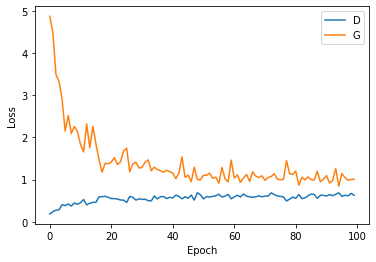

In [16]:
epoch = [i for i in range(n_epochs)]
plt.plot(epoch, history['D'])
plt.plot(epoch, history['G'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['D', 'G'])

plt.savefig(path_data+'/graph.png', dpi=300)
plt.show()

# Result

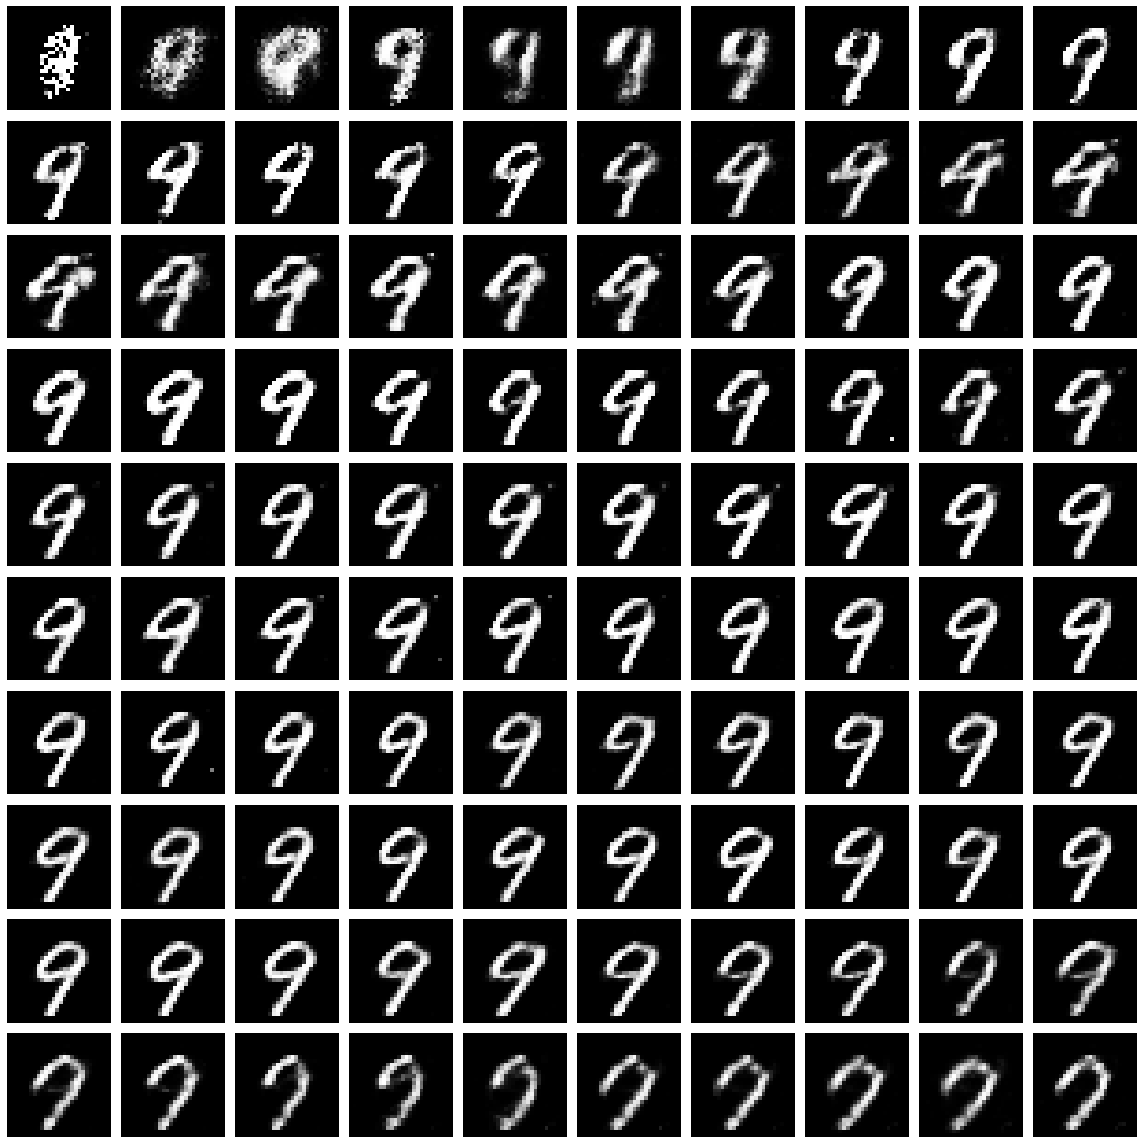

In [17]:
fig = plt.figure(figsize=(16, 16))
for idx, image in enumerate(list_test):
  fig.add_subplot(10, 10, idx+1)
  plt.axis('off')
  plt.imshow(image[0], cmap='gray')

fig.tight_layout()
plt.savefig(path_data+'/history_result.png', dpi=300)
plt.show()

In [18]:
z = torch.zeros(batch_size, z_dim)
z += (0.1**0.5)*torch.randn(batch_size, z_dim)
z = z.cuda()

image_fake = generator(z)
image_fake = image_fake.cpu().detach().numpy()

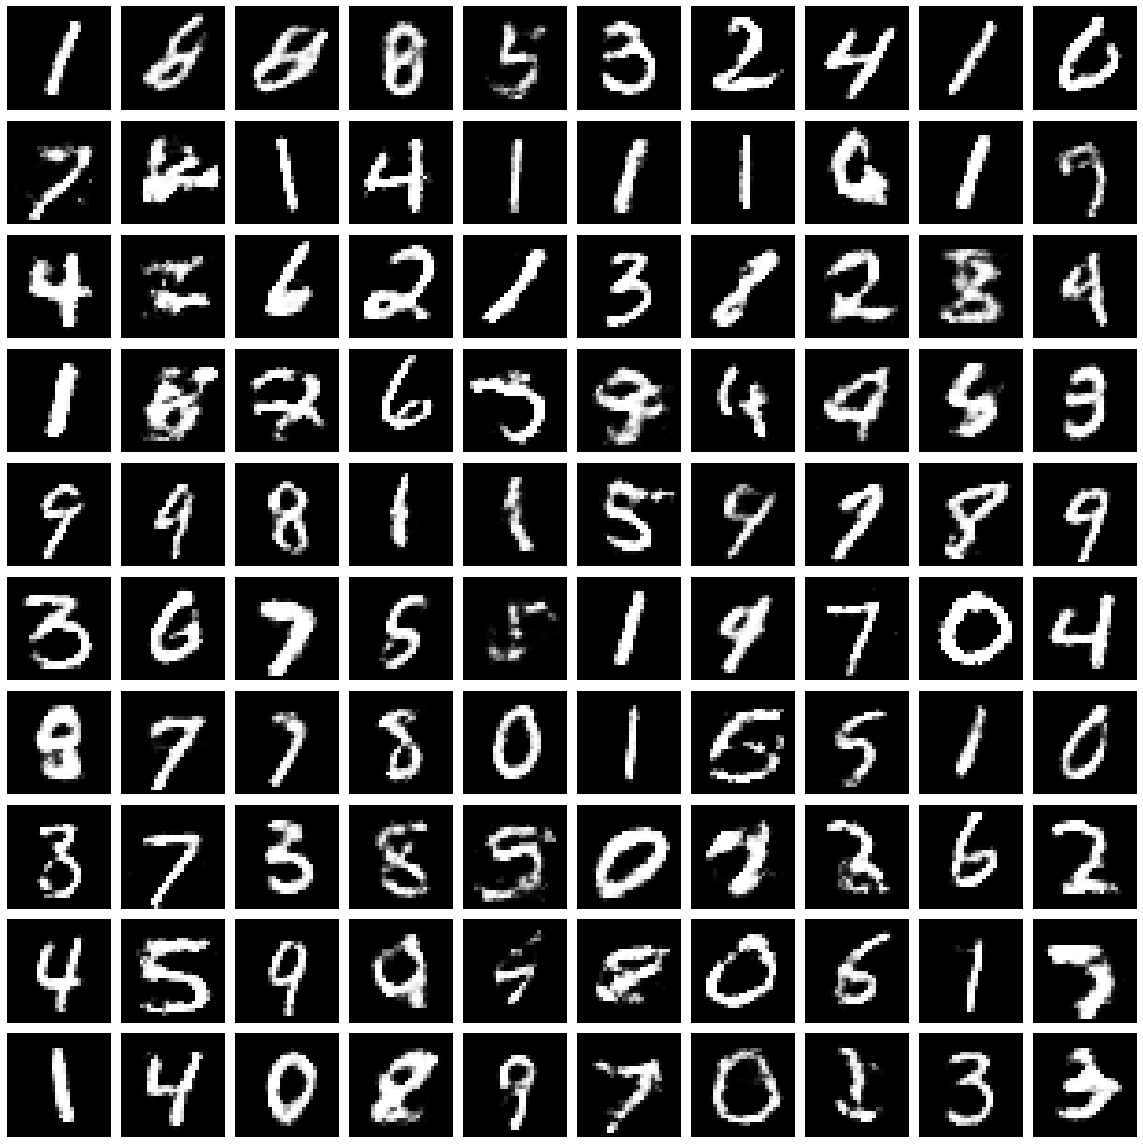

In [19]:
fig = plt.figure(figsize=(16, 16))
for idx, image in enumerate(image_fake[:100]):
  fig.add_subplot(10, 10, idx+1)
  plt.axis('off')
  plt.imshow(image, cmap='gray')

fig.tight_layout()
plt.savefig(path_data+'/random_result.png', dpi=300)
plt.show()

## Maxout Graph

In [21]:
maxout = discriminator.model[1]
weight = maxout.weight.cpu().detach().numpy()
bias = maxout.bias.cpu().detach().numpy()[0]
lines = []

In [22]:
x = np.linspace(-10,10,100)
for i in range(3):
  y = weight[i] * x + bias[i]
  lines.append(y)

max_line = np.max(lines, axis=0)

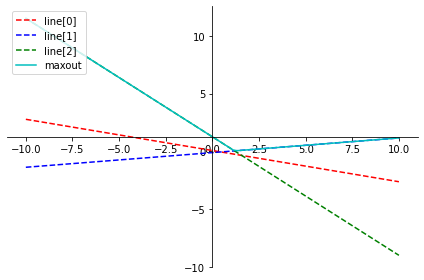

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.plot(x, lines[0], '--r', label='line[0]')
plt.plot(x, lines[1], '--b', label='line[1]')
plt.plot(x, lines[2], '--g', label='line[2]')
plt.plot(x, np.max(lines, axis=0), '-c', label='maxout')

fig.tight_layout()
plt.legend(loc='upper left')
plt.savefig(path_data+'/maxout_result.png', dpi=300)
plt.show()